In [1]:
import pandas as pd
import os
import json
import time
from urllib.parse import urlparse

import matplotlib
#matplotlib.use('AGG')
import matplotlib.pyplot as plt

import numpy as np
import seaborn as sns
sns.set_theme(style="white", rc={
        "axes.edgecolor": "black",
        "ytick.color":"black",
        'axes.spines.left': False,      
        'axes.spines.right': False,
        'axes.spines.top': False})

#ml process
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, validation_curve, learning_curve
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer

#preprocessing
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder

#models
import graphviz
from sklearn.tree import DecisionTreeClassifier, export_text, plot_tree, export_graphviz
from sklearn.svm import LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import SGDClassifier, LogisticRegression, RidgeClassifierCV
from sklearn.ensemble import StackingClassifier, RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier

#metrics
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, make_scorer, confusion_matrix, ConfusionMatrixDisplay

#save
from joblib import dump, load

import mlflow
import mlflow.sklearn

In [2]:
import sqlite3
# Read sqlite query results into a pandas DataFrame
conn = sqlite3.connect("mushrooms.sqlite")
df = pd.read_sql_query("SELECT * from data", conn)

In [3]:
class Mushroom_ml():
    
    
    def __init__(self,df, target):
        """--------------------------------------------------------
        Initialize Object with Data

            Parameters
            df, target

            Returns
            None 
        ---------------------------------------------------------"""
        self.df = df
        self.X = df.drop(target, axis = 1)
        self.y = df[target]
        self.target = target
        self.list_models = [
            LogisticRegression(),
            SGDClassifier(),
            RidgeClassifierCV(),
            LinearSVC(),
            KNeighborsClassifier(),
            DecisionTreeClassifier(),
            StackingClassifier([
                    ('model_1', KNeighborsClassifier(n_neighbors=10)),('model_2', RandomForestClassifier())
                ], final_estimator=DecisionTreeClassifier()),
            AdaBoostClassifier(),
            GradientBoostingClassifier(),
            RandomForestClassifier(n_estimators=10)
        ]
        self.precision_scorer = make_scorer(self.score_precision, greater_is_better = True) 
#--------------------------------------------------------------------
#--------------------------------------------------------------------

    def df_to_html(self, df, df_name:str, lines:int = 5, columns:int = 5):
        """--------------------------------------------------------
        Transform df to HTML string
            Parameters
            dataframe, sample, nb_lines displayed, nb_column displayed

            Returns
            dict with target name and string of buffer img source
        ---------------------------------------------------------"""

        return df.to_html(max_rows=lines, max_cols=columns) 
    
#--------------------------------------------------------------------
#--------------------------------------------------------------------

    def score_precision(self, y, y_pred):
        """--------------------------------------------------------
        Define function precision in order to be used with a make_scorer function
        included precision label target("enible")

        Parameters
        y and y_pred

        Returns
        precision score
        ---------------------------------------------------------"""
        return precision_score(y, y_pred, average = "binary", pos_label="edible")
    
    #--------------------------------------------------------------------
    #--------------------------------------------------------------------

    def train_test_split(self, X, y):
        """--------------------------------------------------------
        separate dataset in training and testing sets

            Parameters
            X(features), y(target)

            Returns
            datasets: X_train, X_test, y_train, y_test
        ---------------------------------------------------------"""
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

        return X_train, X_test, y_train, y_test
#--------------------------------------------------------------------
#--------------------------------------------------------------------

    def test_models(self, list_models='default', encoder=OneHotEncoder(handle_unknown='ignore'), scoring='default', show=False):
        """--------------------------------------------------------
        Test list of models and give mean accuracy after a cross validation
            
            Parameters
            list of models, Encoder, scoring

            Returns
            String of
        ---------------------------------------------------------"""
        if list_models == 'default':
            list_models=self.list_models
            
        if scoring == 'default':
            scoring = self.precision_scorer
            
        X_train, X_test, y_train, y_test = self.train_test_split(self.X, self.y)
        
        cat = X_train.select_dtypes(exclude = [np.number]).columns
        transformer = make_column_transformer((encoder, cat))
            
        final_string=""
        for model in list_models:
            
            final_model = make_pipeline(transformer, model)
            string=f"model : {model} => {cross_val_score(final_model, X_train, y_train, cv=4, scoring=scoring).mean()}"
            
            if show:
                print(string)
                
            final_string+= ("\n" + string)
            

        return final_string
    
#--------------------------------------------------------------------
#--------------------------------------------------------------------

    def score_model(self, sendmodel=DecisionTreeClassifier(), encoder=OneHotEncoder(handle_unknown='ignore'), display=True):
        """--------------------------------------------------------
        Train a Model and Score Metrics. Add Monitoring parameters and launch save models

            Parameters
            Model, Encoder, Display

            Returns
            String of
        ---------------------------------------------------------"""

        X_train, X_test, y_train, y_test = self.train_test_split(self.X, self.y)
        
        cat = X_train.select_dtypes(exclude = [np.number]).columns
        transformer = make_column_transformer((encoder, cat))
        
        with mlflow.start_run():
            model = make_pipeline(transformer, sendmodel)
            self.fit_model = model.fit(X_train, y_train)
            y_pred = model.predict(X_test)

            precision=precision_score(y_test, y_pred, average = "binary", pos_label="edible")
            accuracy=accuracy_score(y_test, y_pred)
            
            mlflow.log_param("cols", ('||').join(self.X.columns))
            mlflow.log_param("parameters", json.dumps(self.fit_model.steps[1][1].get_params()))
            mlflow.log_metric("accuracy", accuracy)
            mlflow.log_metric("precision", precision)
            
 
                            
        results = [f'accuracy : {accuracy}',
        f'precision : {precision}',
        ]
        for result in results:
            print(result)

        listing = list(y_test.unique())
        listing.sort()
        cm = confusion_matrix(y_test, y_pred, labels=listing)
        fig, ax = plt.subplots(figsize=(8,6))
        disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=listing, )
        disp.plot(cmap=plt.cm.Blues, ax=ax)
        fig.suptitle(f'{sendmodel} Confusion matrix', fontweight='bold', fontsize=20);
        plt.show()
             
        #create in db
        name_model=f'{str(sendmodel)}_{int(time.time())}'
        ml_path=f'/models/load_models/{name_model}'
        cursor = conn.cursor()
        cursor.execute("""
        INSERT INTO ml(
        name,
        cols,
        model,
        parameters,
        accuracy,
        precision,
        path,
        display) 
        VALUES (?,?,?,?,?,?,?,?)
        """,(
            f'{str(sendmodel)}_{int(time.time())}',
            ('||').join(self.X.columns),
            str(sendmodel),
            json.dumps(self.fit_model.steps[1][1].get_params()),
            float(precision),
            float(accuracy),
            ml_path,
            display         
        ))

        conn.commit()
        self.save_model(sendmodel, encoder, ml_path)
        

    #--------------------------------------------------------------------
    #--------------------------------------------------------------------
    
    
    
    def save_model(self, sendmodel, encoder, ml_path):
        """--------------------------------------------------------
        Create fit_model with full X and y parameters and dump model 

            Parameters
            Model
            Encoder
            ml_path

            Returns
            String
        ---------------------------------------------------------"""
                
        model = make_pipeline(encoder, sendmodel)
        full_model = model.fit(self.X, self.y)
        
        dump(full_model, f'app/{ml_path}')       
        
        return 'Save Model Successfully'
        
    
    def features_importances(self, encoder=OneHotEncoder()):
        """--------------------------------------------------------
        Train a Model of RandomForestClassificator and catch predict important_features

            Parameters
            Encoder

            Returns
            Dataframe
        ---------------------------------------------------------"""
        
        #split
        X_train, X_test, y_train, y_test = self.train_test_split(self.X, self.y)

        #define model and encode
        sendmodel=DecisionTreeClassifier()
        
        cat = X_train.select_dtypes(exclude = [np.number]).columns
        transformer = make_column_transformer((encoder, cat))
        
        model = make_pipeline(transformer, sendmodel)
                
        #fit
        fit_model = model.fit(X_train, y_train)
        

        #create fi(dataframe) with features importances of encoding
        fi = pd.DataFrame(list(zip(fit_model.steps[0][1].get_feature_names_out(),
                               fit_model.steps[1][1].feature_importances_)))

        sumdf=pd.DataFrame([[]])
        for col in list(fit_model.steps[0][1].feature_names_in_):
            somme=[]
            resultat=0

            for i in range(len(fi)):

                if col in fi.iloc[i][0]:
                    somme.append(pow((fi.iloc[i][1]), 2))
                    resultat=sum(somme)

                sumdf[col]=np.sqrt(resultat)

        sumdf = sumdf.T
        sumdf.columns = ['feature_importance']
        sumdf['name']=sumdf.index
        sumdf.sort_values(by = 'feature_importance', ascending = False, inplace=True)
        
        fig, ax = plt.subplots(figsize=(7, 7))
        
        plot = sns.barplot(x='feature_importance', y='name', data=sumdf, color="r", ax=ax, orient='h')
        plt.show()
        
        return sumdf
    
    #--------------------------------------------------------------------
    #-------------------------------------------------------------------- 
    
    
    def feature_selection(self, list_val_features=[], sendmodel=DecisionTreeClassifier(), plot_df=False):
        """--------------------------------------------------------
        Evaluate witch feature have the better score and plot results

            Parameters
            sendmodel, list of validate other features

            Returns
            dataset
        ---------------------------------------------------------"""
    
        liste = self.df.drop(['_class'] + list_val_features, axis=1).columns

        results_test_models = []
        for col in liste:
            df_test = Mushroom_ml(df[['_class', col] + list_val_features], '_class')
            results_test_models.append(float((df_test.test_models([DecisionTreeClassifier()])).split(' => ')[1]))

        df_results = pd.DataFrame({'feature':liste, 'results':results_test_models}).sort_values(by = 'results', ascending = False)
        if plot_df:
            fig, ax = plt.subplots(figsize=(7, 7))

            plot = sns.barplot(x='results', y='feature', data=df_results, color="r", ax=ax, orient='h')
            plt.show()
            
        return df_results
    
    #--------------------------------------------------------------------
    #--------------------------------------------------------------------
    
    def tree_vis(self, sendmodel=DecisionTreeClassifier(), encoder=OneHotEncoder()):
        """--------------------------------------------------------
        Train a Model of DecisionTreeClassifier and viz decision tree of features

            Parameters
            Encoder

            Returns
            graphique in .dot format
        ---------------------------------------------------------"""
        
        #split
        X_train, X_test, y_train, y_test = self.train_test_split(self.X, self.y)
              
        #model = make_pipeline(transformer, sendmodel)
        preprocessing=encoder.fit_transform(X_train)

        #fit
        tree_ml = sendmodel.fit(preprocessing, y_train)

        features = encoder.get_feature_names_out()
        
        dot_data = export_graphviz(tree_ml, out_file=None, 
                                        feature_names=features,  
                                        class_names=tree_ml.classes_,  
                                        filled=True, rounded=True,  
                                        special_characters=True)
        graph = graphviz.Source(dot_data)
        self.text_tree = export_text(tree_ml, feature_names=list(features))

        return graph
    
    #--------------------------------------------------------------------
    #--------------------------------------------------------------------
    
       
    def grid_model(self, model, params, scoring='default'):
        """--------------------------------------------------------
        Evaluate better params for a model scoring send it

            Parameters
            model
            params
            scoring

            Returns
            String with best params
        ---------------------------------------------------------"""
        
        if scoring == 'default':
            scoring = {
                "precision_score": self.precision_scorer,
                "accuracy": "accuracy"
            }
        
        X_train, X_test, y_train, y_test = self.train_test_split(self.X, self.y)

        #define model and encode
        encoder=OneHotEncoder()

        #encode
        preprocessing = encoder.fit_transform(X_train)

        # Instantiate the RandomizedSearchCV object: tree_cv
        model_cv = GridSearchCV(model, params, cv=5, scoring = scoring, refit="precision_score")

        # Fit it to the data
        model_cv.fit(preprocessing,y_train)

        # Print the tuned parameters and score
        print("Tuned Decision Tree Parameters: {}".format(model_cv.best_params_))
        print("Best score is {}".format(model_cv.best_score_))
        
        return model_cv.best_params_
    
    #--------------------------------------------------------------------
    #-------------------------------------------------------------------- 
    
    def learning_graph(self, sendmodel=DecisionTreeClassifier(), encoder=OneHotEncoder()):

        """--------------------------------------------------------
        Graph learning curve for better sample of records

        Parameters
        model
        encoder

        Returns
        None
        ---------------------------------------------------------"""

        #split
        X_train, X_test, y_train, y_test = self.train_test_split(self.X, self.y)

        #encode
        preprocessing = encoder.fit_transform(X_train)          

        N, train_score, val_score = learning_curve(sendmodel,
                                                   preprocessing,
                                                   y_train,
                                                   train_sizes = np.linspace(0.2, 1.0, 10),
                                                   cv = 5)

        plt.plot(N, train_score.mean(axis = 1), label = 'train')
        plt.plot(N, val_score.mean(axis = 1), label = 'validation')
        plt.xlabel('train_sizes')
        plt.legend()

        return None
            
    #--------------------------------------------------------------------
    #-------------------------------------------------------------------- 

# Analyse de la précision des models selon une CROSS VALIDATION (encoder=OneHotEncoder())

In [4]:
mushroom = Mushroom_ml(df.drop(['_id'], axis=1), '_class')

In [5]:
a = mushroom.test_models(show=True)

model : LogisticRegression() => 0.9992947813822285
model : SGDClassifier() => 1.0
model : RidgeClassifierCV() => 0.9992947813822285
model : LinearSVC() => 1.0
model : KNeighborsClassifier() => 0.9992947813822285
model : DecisionTreeClassifier() => 0.9992947813822285
model : StackingClassifier(estimators=[('model_1',
                                KNeighborsClassifier(n_neighbors=10)),
                               ('model_2', RandomForestClassifier())],
                   final_estimator=DecisionTreeClassifier()) => 1.0
model : AdaBoostClassifier() => 1.0
model : GradientBoostingClassifier() => 0.9992947813822285
model : RandomForestClassifier(n_estimators=10) => 1.0


# FEATURE SELECTION (MODEL:DECISIONTREE, ENCODER:ONEHOTENCODER)

## Features_importances (distance euclidienne) des coefficients

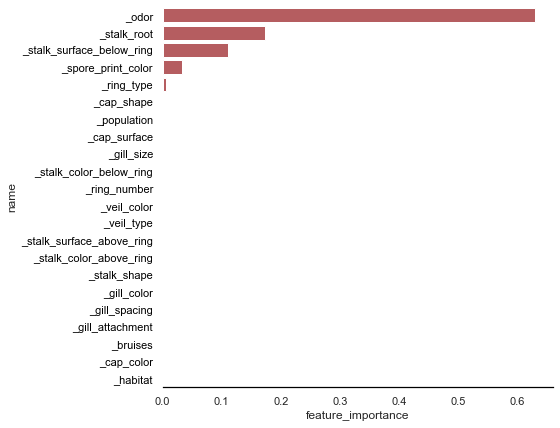

In [6]:
a = mushroom.features_importances()

## Evaluations des features offrants les meilleurs résultats en matière de Précision

In [7]:
mushroom.feature_selection(sendmodel=DecisionTreeClassifier()).head()

,feature,results
4,_odor,0.973518
6,_gill_spacing,0.913931
19,_spore_print_color,0.892613
17,_ring_number,0.883749
3,_bruises,0.821513


In [8]:
mushroom.feature_selection(['_odor'],sendmodel=DecisionTreeClassifier()).head()

,feature,results
18,_spore_print_color,0.989512
11,_stalk_surface_below_ring,0.981894
20,_habitat,0.981617
2,_cap_color,0.979252
13,_stalk_color_below_ring,0.978906


In [9]:
mushroom.feature_selection(['_odor', '_habitat'],sendmodel=DecisionTreeClassifier()).head()

,feature,results
18,_spore_print_color,0.995769
2,_cap_color,0.993682
9,_stalk_root,0.991946
3,_bruises,0.991247
10,_stalk_surface_above_ring,0.990205


In [10]:
mushroom.feature_selection(['_odor', '_habitat', '_cap_color'],sendmodel=DecisionTreeClassifier()).head()

,feature,results
8,_stalk_root,1.000000
2,_bruises,0.998239
17,_spore_print_color,0.998239
18,_population,0.997182
4,_gill_spacing,0.997182


# CONSTRUCTIONS DE MODELS

## Evaluation de la sélection avec les modèles

In [11]:
mushroom=Mushroom_ml(df[['_class','_odor', '_habitat', '_cap_color', '_bruises']],'_class')

In [12]:
a = mushroom.test_models(show=True)

model : LogisticRegression() => 0.9785492964791251
model : SGDClassifier() => 0.9943740931575085
model : RidgeClassifierCV() => 0.973517888699717
model : LinearSVC() => 0.9926361461089682
model : KNeighborsClassifier() => 1.0
model : DecisionTreeClassifier() => 0.9982394366197183
model : StackingClassifier(estimators=[('model_1',
                                KNeighborsClassifier(n_neighbors=10)),
                               ('model_2', RandomForestClassifier())],
                   final_estimator=DecisionTreeClassifier()) => 0.9978863292750855
model : AdaBoostClassifier() => 0.9919472078549135
model : GradientBoostingClassifier() => 0.9936822250933147
model : RandomForestClassifier(n_estimators=10) => 0.9992957746478873


## KNeighborsClassifier

In [13]:
a = mushroom.test_models([KNeighborsClassifier()], show=True)

model : KNeighborsClassifier() => 1.0


### SCORE Model avec KNeighborsClassifier

accuracy : 0.999627004848937
precision : 1.0


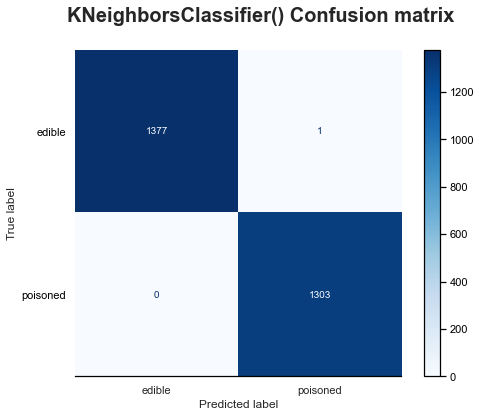

In [14]:
mushroom.score_model(KNeighborsClassifier())

### GRIDSEARCH pour saisir les meilleurs hyper parametres (métrique précision)

In [15]:
mushroom.grid_model(KNeighborsClassifier(), {
    "n_neighbors" : range(1,10),
    "metric": ["euclidean", "manhattan", "minkowski"]
})

Tuned Decision Tree Parameters: {'metric': 'euclidean', 'n_neighbors': 1}
Best score is 1.0


{'metric': 'euclidean', 'n_neighbors': 1}

### SCORE Model avec KNeighborsClassifier(meilleurs parametres)

accuracy : 0.999627004848937
precision : 1.0


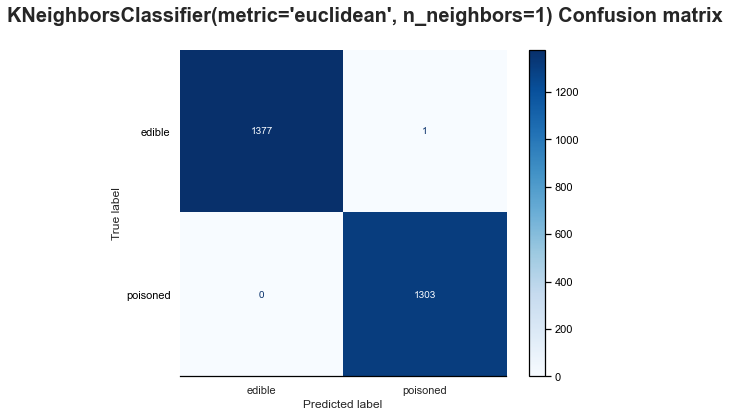

In [16]:
mushroom.score_model(KNeighborsClassifier(n_neighbors=1, metric='euclidean'))

### Analyse Learning Curve

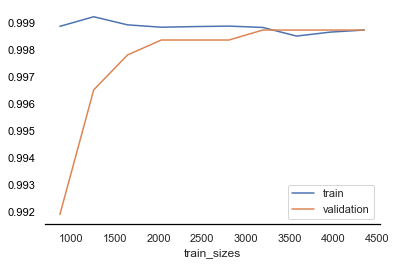

In [17]:
mushroom.learning_graph(sendmodel=KNeighborsClassifier(n_neighbors=1, metric='euclidean'))

## RidgeClassifierCV

In [18]:
a = mushroom.test_models([RidgeClassifierCV()], show=True)

model : RidgeClassifierCV() => 0.973517888699717


### SCORE Model avec RidgeClassifierCV

accuracy : 0.9839612085042895
precision : 0.9697396199859254


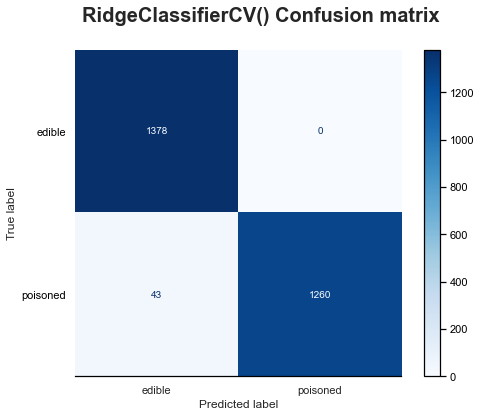

In [19]:
mushroom.score_model(RidgeClassifierCV())

### GRIDSEARCH pour saisir les meilleurs hyper parametres (métrique précision)

In [20]:
mushroom.grid_model(RidgeClassifierCV(), {
    'alphas' : [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
})

Tuned Decision Tree Parameters: {'alphas': 0.1}
Best score is 0.9735406571849318


{'alphas': 0.1}

### SCORE Model avec RidgeClassifierCV(meilleurs parametres)

accuracy : 0.9839612085042895
precision : 0.9697396199859254


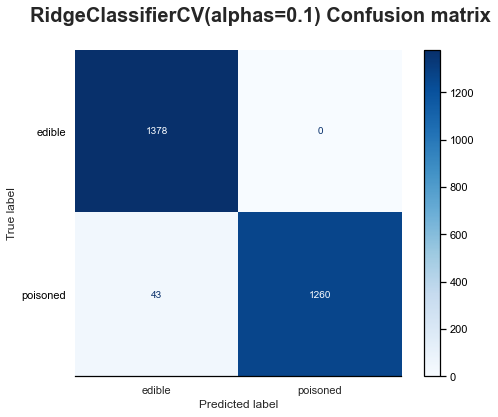

In [21]:
mushroom.score_model(RidgeClassifierCV(alphas=0.1))

### Analyse Learning Curve

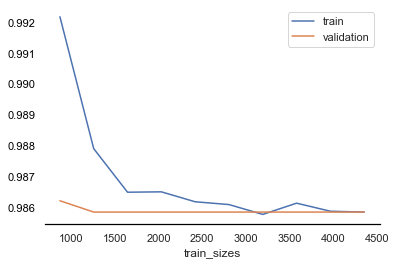

In [22]:
mushroom.learning_graph(sendmodel=RidgeClassifierCV(alphas=0.1))

## LogisticRegression

In [23]:
a = mushroom.test_models([LogisticRegression()], show=True)

model : LogisticRegression() => 0.9785492964791251


### SCORE Model avec LogisticRegression

accuracy : 0.9858261842596047
precision : 0.9758522727272727


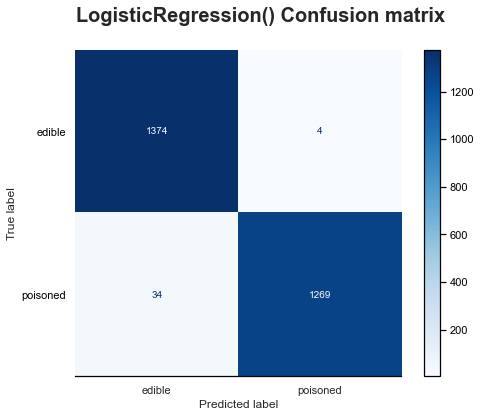

In [24]:
mushroom.score_model(LogisticRegression())

### GRIDSEARCH pour saisir les meilleurs hyper parametres (métrique précision)

In [25]:
mushroom.grid_model(LogisticRegression(), {
    'C' : [10, 1.0, 0.1, 0.01],
})

Tuned Decision Tree Parameters: {'C': 10}
Best score is 0.9919389319560793


{'C': 10}

### SCORE Model avec LogisticRegression(meilleurs parametres)


accuracy : 0.9962700484893696
precision : 0.9927953890489913


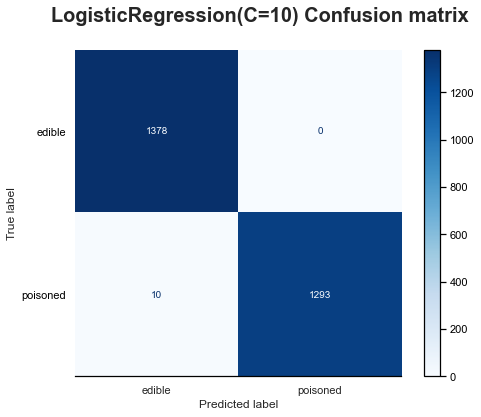

In [26]:
mushroom.score_model(LogisticRegression(C=10))

### Analyse Learning Curve

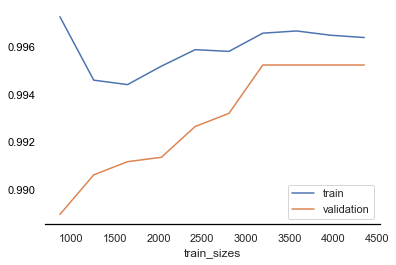

In [27]:
mushroom.learning_graph(sendmodel=LogisticRegression(C=10))

## DECISIONTREECLASSIFIER

### SCORE Model avec DecisionTreeClassifier()

accuracy : 0.999627004848937
precision : 1.0


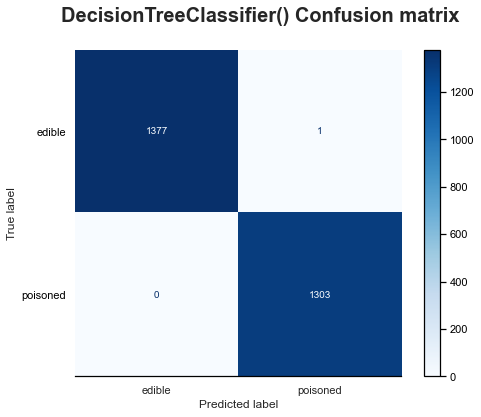

In [28]:
mushroom.score_model()

### GRIDSEARCH pour saisir les meilleurs hyper parametres (métrique précision)

In [29]:
mushroom.grid_model(DecisionTreeClassifier(), {
    "criterion" : ['gini', 'entropy','log_loss'],
    "max_depth" : range(4,15)
})

Tuned Decision Tree Parameters: {'criterion': 'gini', 'max_depth': 9}
Best score is 0.9982412931013144


{'criterion': 'gini', 'max_depth': 9}

### SCORE Model avec DecisionTreeClassifier(meilleurs parametres)

accuracy : 0.999627004848937
precision : 1.0


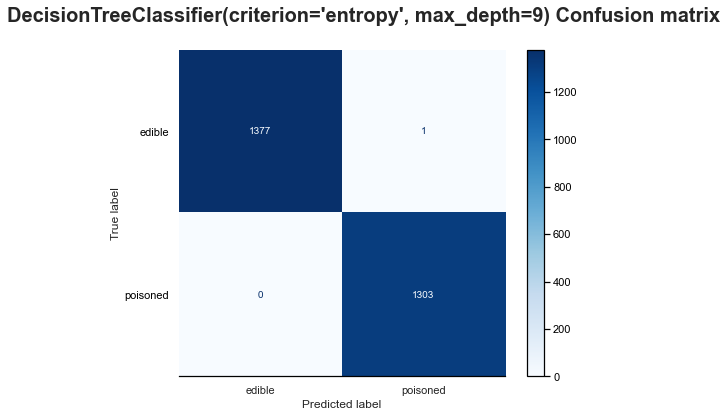

In [30]:
mushroom.score_model(DecisionTreeClassifier(criterion='entropy',max_depth=9,min_samples_leaf=1,min_samples_split=2))

### Analyse Learning Curve

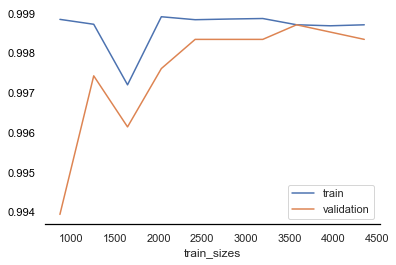

In [31]:
mushroom.learning_graph(sendmodel=DecisionTreeClassifier(criterion='entropy',max_depth=9,min_samples_leaf=1,min_samples_split=2))

## OUTWORK BEST PRATICAL FEATURES

In [32]:
mushroom=Mushroom_ml(
    df[['_class',
        '_odor',
        '_habitat',
        '_cap_color',
        '_population',
        '_bruises'
    ]],'_class')

accuracy : 1.0
precision : 1.0


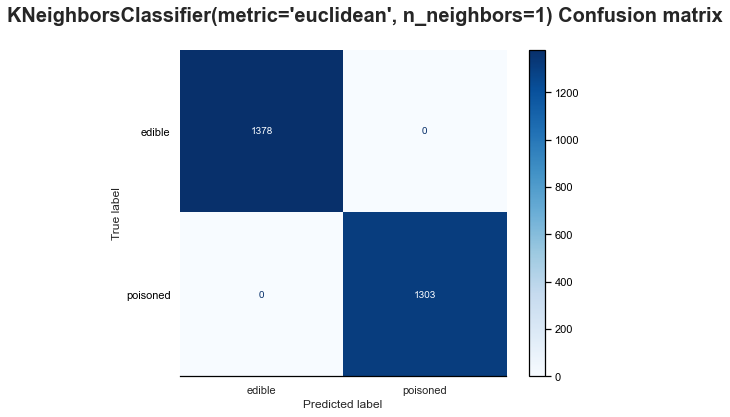

In [33]:
mushroom.score_model(KNeighborsClassifier(n_neighbors=1, metric='euclidean'), display=False)

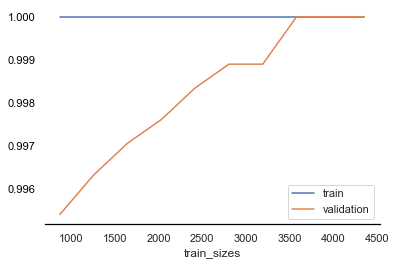

In [34]:
mushroom.learning_graph(KNeighborsClassifier(n_neighbors=1, metric='euclidean'))

### SCORE MODEL

accuracy : 1.0
precision : 1.0


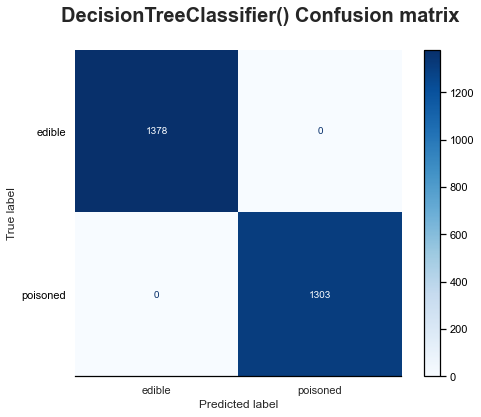

In [35]:
mushroom.score_model(DecisionTreeClassifier(), display=False)

### Gridsearch

In [36]:
mushroom.grid_model(DecisionTreeClassifier(), {
    "criterion" : ['gini', 'entropy','log_loss'],
    "max_depth" : range(4,15)
})

Tuned Decision Tree Parameters: {'criterion': 'gini', 'max_depth': 10}
Best score is 1.0


{'criterion': 'gini', 'max_depth': 10}

### SCORE WITH BEST_PARAMS

accuracy : 1.0
precision : 1.0


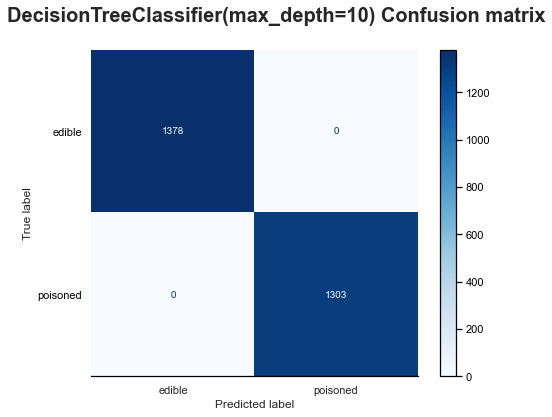

In [37]:
mushroom.score_model(DecisionTreeClassifier(max_depth=10), display=False)

### Analyse Learning Curve

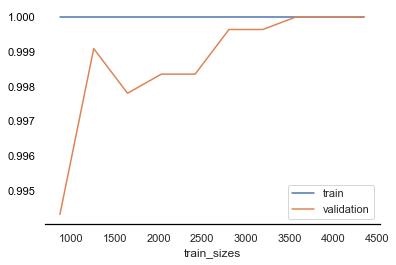

In [38]:
mushroom.learning_graph()

### Plot Tree

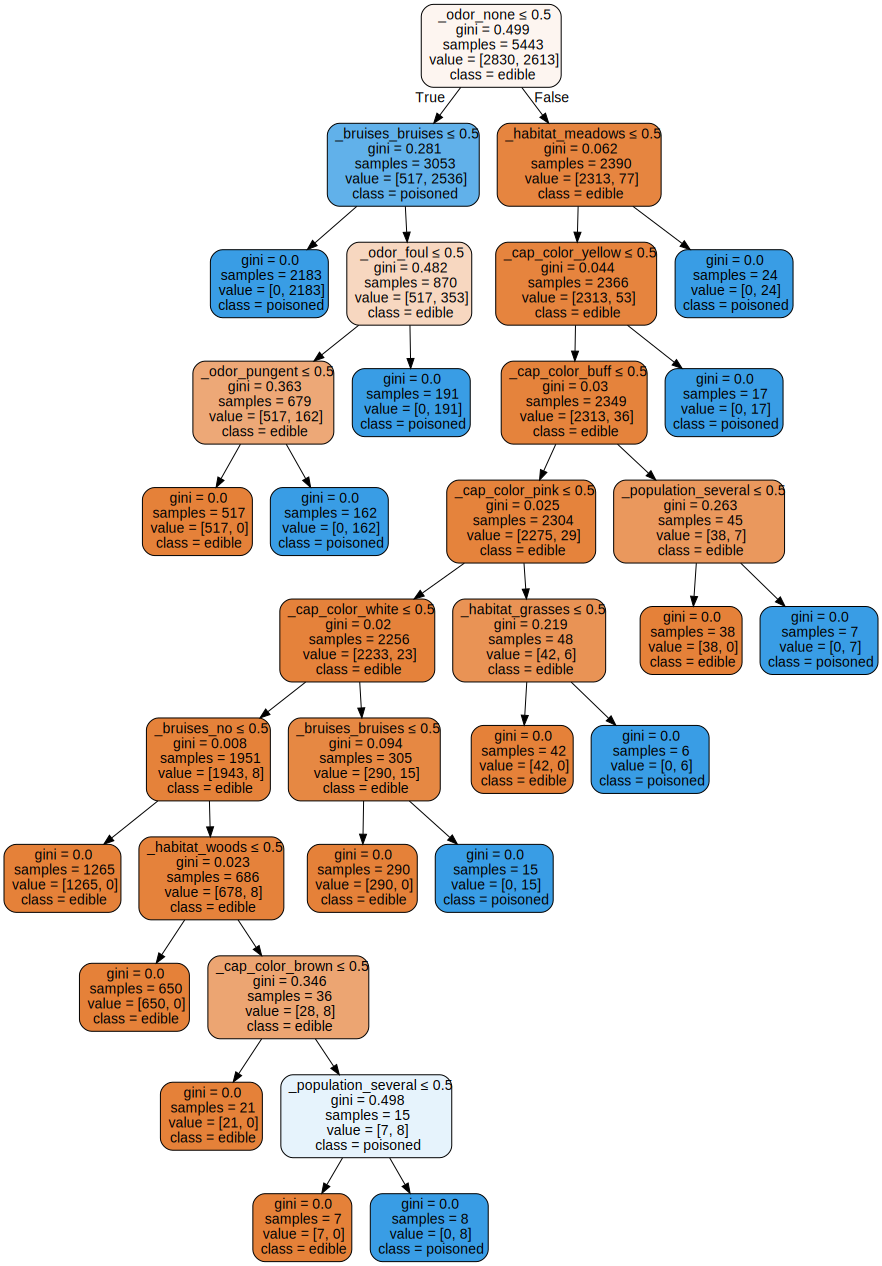

In [39]:
mushroom.tree_vis()